In [1]:
import sqlite3
import os
import numpy as np
import matplotlib.pyplot as plt
import json
results = "../results/"

In [2]:
def get_timestamps(input_name, model_name, output_name, experiment_name):
    conn = sqlite3.connect('../results/results_lookup.db')
    c = conn.cursor()
    timestamps = []
    for row in c.execute('''
        SELECT * FROM experiments 
            WHERE input=?
                AND output=?
                AND model=?
                AND experiment=?
    ''', (input_name, output_name, model_name, experiment_name)):
        timestamps.append(row[0])
    print(str(len(timestamps)) + " entries found")
    return timestamps

In [3]:
def get_results(timestamps):
    train_results, test_results = [], []
    for trial_timestamp in timestamps:    
        with open(results + trial_timestamp + "/train.json") as train_fp:
            train_results.append(json.load(train_fp))
        with open(results + trial_timestamp + "/test.json") as test_fp:
            test_results.append(json.load(test_fp))
    return train_results, test_results
   
def get_keep_pcts(test_results):
    return sorted(list(test_results[0].keys()))[::-1]

def get_label_names(test_results, keep_pcts):
    return test_results[0][keep_pcts[0]][0]["class_1_name"].capitalize(), \
           test_results[0][keep_pcts[0]][0]["class_2_name"].capitalize()

In [4]:
def get_left_out_accs(test_results, keep_pcts):
    left_out_final_num_accs_raw = np.array([[trial_test_results[keep_pct][-1]["left_out_num_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
    left_out_final_num_accs = np.mean(left_out_final_num_accs_raw, axis=0)
    left_out_final_num_accs_std = np.std(left_out_final_num_accs_raw, axis=0)
    left_out_final_col_accs_raw = np.array([[trial_test_results[keep_pct][-1]["left_out_col_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
    left_out_final_col_accs = np.mean(left_out_final_col_accs_raw, axis=0)
    left_out_final_col_accs_std = np.std(left_out_final_col_accs_raw, axis=0)
    return (left_out_final_num_accs, left_out_final_num_accs_std), \
           (left_out_final_col_accs, left_out_final_col_accs_std)

def get_non_left_out_accs(test_results, keep_pcts):
    non_left_out_final_num_accs_raw = np.array([[trial_test_results[keep_pct][-1]["non_left_out_num_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
    non_left_out_final_num_accs = np.mean(non_left_out_final_num_accs_raw, axis=0)
    non_left_out_final_num_accs_std = np.std(non_left_out_final_num_accs_raw, axis=0)
    non_left_out_final_col_accs_raw = np.array([[trial_test_results[keep_pct][-1]["non_left_out_col_acc"] for keep_pct in keep_pcts] for trial_test_results in test_results])
    non_left_out_final_col_accs = np.mean(non_left_out_final_col_accs_raw, axis=0)
    non_left_out_final_col_accs_std = np.std(non_left_out_final_col_accs_raw, axis=0)
    return (non_left_out_final_num_accs, non_left_out_final_num_accs_std), \
           (non_left_out_final_col_accs, non_left_out_final_col_accs_std)

In [37]:
def get_directory(input_name, model_name, output_name, experiment_name):
    directory = "../plots/{}/{}/{}/{}/".format(experiment_name, output_name, input_name, model_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    return directory

def plot(keep_pcts, label_names, left_out_accs, non_left_out_accs, directory):
    for i in range(len(label_names)):
        label_name = label_names[i]
        left_out_final_accs, left_out_final_accs_std = left_out_accs[i]
        non_left_out_final_accs, non_left_out_final_accs_std = non_left_out_accs[i]

        plt.errorbar(keep_pcts[:0:-1], left_out_final_accs[:0:-1], yerr=left_out_final_accs_std[:0:-1])
        plt.errorbar(keep_pcts[:0:-1], non_left_out_final_accs[:0:-1], yerr=non_left_out_final_accs_std[:0:-1])
        plt.ylim(0, 1)
        plt.xlabel('Keep %')
        plt.ylabel('Test Accuracy')
        plt.title(r'Final Hold-Out $\bf {}$ Classification Accuracy v. Keep %'.format(label_name))
        plt.legend(["Unseen Combinations", "Seen Combinations"], loc='best')
        plt.grid(True)
        plt.xticks(keep_pcts[:0:-1], labels=[str(i + 1) + " / " + str(len(keep_pcts)) for i in range(len(keep_pcts))])
        plt.yticks([x / 10. for x in range(0, 11)])
        plt.savefig(directory + "hold_out_{}_acc.pdf".format(label_name.lower()))
        plt.show()

In [49]:
def run_all(input_name, model_name, output_name, experiment_name):
    timestamps = get_timestamps(input_name, model_name, output_name, experiment_name)
    _, test_results = get_results(timestamps)
    keep_pcts = get_keep_pcts(test_results)
    label_names = get_label_names(test_results, keep_pcts)
    left_out_accs = get_left_out_accs(test_results, keep_pcts)
    non_left_out_accs = get_non_left_out_accs(test_results, keep_pcts)
    print(left_out_accs)
    directory = get_directory(input_name, model_name, output_name, experiment_name)
    plot(keep_pcts, label_names, left_out_accs, non_left_out_accs, directory)

In [50]:
input_name = "left_out_varied_location_mnist"
model_name = "resnet_no_pool"
output_name = "keep_pct_readout_dump"
experiment_name = "keep_pct_readout_9_class_weighted"

20 entries found
((array([0.98005486, 0.1049997 , 0.00844413, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ]), array([0.00559391, 0.03629219, 0.01091735, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])), (array([1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0.])))


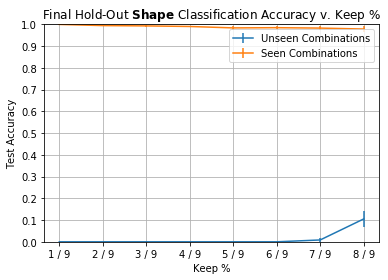

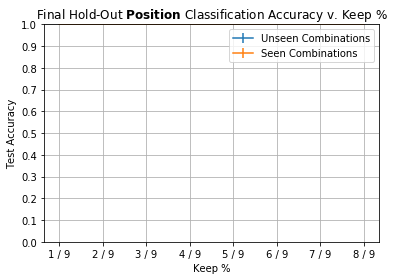

In [51]:
run_all(input_name, model_name, output_name, experiment_name)